<a href="https://colab.research.google.com/github/mrbenbot/wimblepong/blob/main/Wimblepong_Reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Setup Google Colab Environment
%pip install gym
%pip install stable-baselines3[extra]
%pip install imageio pillow
%pip install tensorflowjs




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
# Import necessary libraries
from gymnasium import spaces
import gymnasium as gym

import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecCheckNan
from stable_baselines3.common.monitor import Monitor

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from IPython import display

import os
import imageio
import glob
import math

from IPython.display import display, Image, HTML

import tensorflow as tf
from tensorflow.keras import layers
import torch as th
import numpy as np


# Check versions
print("gym version:", gym.__version__)
print("stable-baselines3 version:", stable_baselines3.__version__)


gym version: 0.29.1
stable-baselines3 version: 2.3.2


In [3]:
COURT_HEIGHT = 800
COURT_WIDTH = 1200
PADDLE_HEIGHT = 90
PADDLE_WIDTH = 15
BALL_RADIUS = 12
INITIAL_BALL_SPEED = 10
PADDLE_SPEED_DIVISOR = 15  # Example value, adjust as needed
PADDLE_CONTACT_SPEED_BOOST_DIVISOR = 4  # Example value, adjust as needed
SPEED_INCREMENT = 0.6  # Example value, adjust as needed
SERVING_HEIGHT_MULTIPLIER = 2  # Example value, adjust as needed
PLAYER_COLOURS = {'Player1': 'blue', 'Player2': 'red'}
MAX_COMPUTER_PADDLE_SPEED = 10

In [4]:
rewards_map = {
    "hit_paddle": lambda _: 50,
    "score_point": lambda _: 100,
    "conceed_point": lambda ball, paddle, rally_length: (-abs(ball['y'] - paddle['y']) / max(rally_length, 1))/100,
    # "conceed_point": lambda ball, paddle, rally_length: -0.1,
    "serve": lambda ball_speed: ball_speed / 10,
    "paddle_movement": lambda dy: 0,
    "ball_distance": lambda ball, paddle: 0
}

In [67]:



class Player:
    Player1 = 'Player1'
    Player2 = 'Player2'

class PlayerPositions:
    Initial = 'Initial'
    Reversed = 'Reversed'

class GameEventType:
    ResetBall = 'ResetBall'
    Serve = 'Serve'
    WallContact = 'WallContact'
    HitPaddle = 'HitPaddle'
    ScorePointLeft = 'ScorePointLeft'
    ScorePointRight = 'ScorePointRight'

def get_bounce_angle(paddle_y, paddle_height, ball_y):
    relative_intersect_y = (paddle_y + (paddle_height / 2)) - ball_y
    normalized_relative_intersect_y = relative_intersect_y / (paddle_height / 2)
    return normalized_relative_intersect_y * (math.pi / 4)

class CustomPongEnv(gym.Env):
    def __init__(self):
        super(CustomPongEnv, self).__init__()
        self.action_space = spaces.Box(low=np.array([0, -60]), high=np.array([1, 60]), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -np.inf, -np.inf, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([COURT_WIDTH, COURT_HEIGHT, np.inf, np.inf, COURT_WIDTH, COURT_HEIGHT, 1, 1], dtype=np.float32)
        )
        self.starting_states = [
           {'server': Player.Player1, 'positions_reversed': False, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': True, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player1, 'positions_reversed': True, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': False, 'opponent': Player.Player1, 'player': Player.Player2},
        ]
        self.starting_state_index = 0
        self.serve_delay = 50
        self.serve_delay_counter = 0
        self.direction = 15
        self.is_done = False
        self.frame_count = 0
        self.last_event = None
        self.reset(seed=0)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)
        print("Environment reset")
        starting_state = self.starting_states[self.starting_state_index]
        self.starting_state_index = (self.starting_state_index + 1) % len(self.starting_states)
        server = starting_state['server']
        positions_reversed = starting_state['positions_reversed']
        computer = starting_state['opponent']
        player = starting_state['player']
        self.state = {
            'server': server,
            'positions_reversed': positions_reversed,
            'opponent': computer,
            'player': player,
            Player.Player1: {'x': 0, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'blue'},
            Player.Player2: {'x': COURT_WIDTH - PADDLE_WIDTH, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'red'},
            'ball': {'x': COURT_WIDTH // 2, 'y': COURT_HEIGHT // 2, 'dx': INITIAL_BALL_SPEED, 'dy': INITIAL_BALL_SPEED, 'radius': BALL_RADIUS, 'speed': INITIAL_BALL_SPEED, 'serve_mode': True, 'score_mode': False, 'score_mode_timeout': 0},
            'stats': {'rally_length': 0, 'serve_speed': INITIAL_BALL_SPEED, 'server': server}
        }
        self.is_done = False
        self.apply_meta_game_state()
        self.serve_delay_counter = 0
        self.direction = 30 * np.random.rand()
        self.serve_delay = 100 * np.random.rand()
        self.direction = self.direction if np.random.rand() > 0.5 else -self.direction
        if not os.path.exists('frames'):
            os.makedirs('frames')
        return self._get_obs(), {}

    def apply_meta_game_state(self):
        game_state = self.state
        serving_player = game_state['server']
        positions_reversed = game_state['positions_reversed']
        if serving_player == Player.Player1:
            self.state[Player.Player1]['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
            self.state[Player.Player2]['height'] = PADDLE_HEIGHT
        else:
            self.state[Player.Player1]['height'] = PADDLE_HEIGHT
            self.state[Player.Player2]['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
        if positions_reversed:
            self.state[Player.Player1]['x'] = COURT_WIDTH - PADDLE_WIDTH
            self.state[Player.Player2]['x'] = 0
        else:
            self.state[Player.Player1]['x'] = 0
            self.state[Player.Player2]['x'] = COURT_WIDTH - PADDLE_WIDTH
        ball = self.state['ball']
        server_is_left = (serving_player == Player.Player1 and not positions_reversed) or (serving_player == Player.Player2 and positions_reversed)
        ball['y'] = self.state[serving_player]['height'] / 2 + self.state[serving_player]['y']
        ball['x'] = self.state[serving_player]['width'] + ball['radius'] if server_is_left else COURT_WIDTH - self.state[serving_player]['width'] - ball['radius']
        ball['speed'] = INITIAL_BALL_SPEED
        ball['serve_mode'] = True
        ball['score_mode'] = False
        ball['score_mode_timeout'] = 0
        self.state['stats']['rally_length'] = 0

    def step(self, action):
        button_pressed = action[0] > 0.5
        paddle_direction = action[1]
        model_player_actions = {'button_pressed': button_pressed, 'paddle_direction': paddle_direction}
        computer_player_actions = self.get_computer_player_actions(self.state['opponent'])
        actions = {self.state['opponent']: computer_player_actions, self.state['player']: model_player_actions}
        reward = self.update_game_state(actions, 2.5)
        obs = self._get_obs()
        info = {}
        terminated = self.check_done()
        truncated = False
        return obs, reward, terminated, truncated, info

    def update_game_state(self, actions, delta_time):
        reward = 0
        game_state = self.state
        ball = game_state['ball']
        stats = game_state['stats']
        server = game_state['server']
        paddle_left, paddle_right = (game_state[Player.Player2], game_state[Player.Player1]) if game_state['positions_reversed'] else (game_state[Player.Player1], game_state[Player.Player2])
        model_is_left = (game_state['player'] == Player.Player1 and not game_state['positions_reversed']) or (game_state['player'] == Player.Player2 and game_state['positions_reversed'])
        if ball['score_mode']:
            self.is_done = True
            return 0.01
        elif ball['serve_mode']:
            serving_from_left = (server == Player.Player1 and not game_state['positions_reversed']) or (server == Player.Player2 and game_state['positions_reversed'])
            if serving_from_left:
                ball['x'] = game_state[server]['width'] + ball['radius']
            else:
                ball['x'] = COURT_WIDTH - game_state[server]['width'] - ball['radius']
            if actions[server]['button_pressed']:
                ball['speed'] = INITIAL_BALL_SPEED
                ball['dx'] = INITIAL_BALL_SPEED if serving_from_left else -INITIAL_BALL_SPEED
                ball['serve_mode'] = False
                stats['rally_length'] += 1
                stats['serve_speed'] = abs(ball['dy']) + abs(ball['dx'])
                stats['server'] = server
                if game_state['player'] == server:
                    reward += rewards_map['serve'](abs(ball['dy']) + abs(ball['dx']))
            ball['dy'] = (game_state[server]['y'] + game_state[server]['height'] / 2 - ball['y']) / PADDLE_SPEED_DIVISOR
            ball['y'] += ball['dy'] * delta_time
        else:
            ball['x'] += ball['dx'] * delta_time
            ball['y'] += ball['dy'] * delta_time
            if ball['y'] - ball['radius'] < 0:
                ball['dy'] = -ball['dy']
                ball['y'] = ball['radius']
            elif ball['y'] + ball['radius'] > COURT_HEIGHT:
                ball['dy'] = -ball['dy']
                ball['y'] = COURT_HEIGHT - ball['radius']
            if ball['x'] - ball['radius'] < paddle_left['x'] + paddle_left['width'] and ball['y'] + ball['radius'] > paddle_left['y'] and ball['y'] - ball['radius'] < paddle_left['y'] + paddle_left['height']:
                bounce_angle = get_bounce_angle(paddle_left['y'], paddle_left['height'], ball['y'])
                ball['dx'] = (ball['speed'] + abs(paddle_left['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle_left['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle_left['x'] + paddle_left['width'] + ball['radius']
                ball['speed'] += SPEED_INCREMENT
                stats['rally_length'] += 1
                if paddle_left == game_state['player']:
                    reward += rewards_map["hit_paddle"](stats['rally_length'])
            elif ball['x'] + ball['radius'] > paddle_right['x'] and ball['y'] + ball['radius'] > paddle_right['y'] and ball['y'] - ball['radius'] < paddle_right['y'] + paddle_right['height']:
                bounce_angle = get_bounce_angle(paddle_right['y'], paddle_right['height'], ball['y'])
                ball['dx'] = -(ball['speed'] + abs(paddle_right['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle_right['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle_right['x'] - ball['radius']
                ball['speed'] += SPEED_INCREMENT
                stats['rally_length'] += 1
                if paddle_right == game_state['player']:
                    reward += rewards_map["hit_paddle"](stats['rally_length'])
            if ball['x'] - ball['radius'] < 0:
                ball['score_mode'] = True
                if model_is_left:
                    reward += rewards_map['conceed_point'](ball, paddle_left, stats['rally_length'])
                else:
                    reward += rewards_map['score_point'](stats['rally_length'])
            elif ball['x'] + ball['radius'] > COURT_WIDTH:
                ball['score_mode'] = True
                if not model_is_left:
                    reward += rewards_map['conceed_point'](ball, paddle_right, stats['rally_length'])
                else:
                    reward += rewards_map['score_point'](stats['rally_length'])
        if game_state['positions_reversed']:
            game_state[Player.Player1]['dy'] = actions[Player.Player1]['paddle_direction']
            game_state[Player.Player2]['dy'] = -actions[Player.Player2]['paddle_direction']
        else:
            game_state[Player.Player1]['dy'] = -actions[Player.Player1]['paddle_direction']
            game_state[Player.Player2]['dy'] = actions[Player.Player2]['paddle_direction']
        game_state[Player.Player1]['y'] += game_state[Player.Player1]['dy'] * delta_time
        game_state[Player.Player2]['y'] += game_state[Player.Player2]['dy'] * delta_time
        if model_is_left:
            reward += rewards_map['paddle_movement'](abs(paddle_left['dy']))
        else:
            reward += rewards_map['paddle_movement'](abs(paddle_right['dy']))
        if paddle_left['y'] < 0:
            paddle_left['y'] = 0
        if paddle_left['y'] + paddle_left['height'] > COURT_HEIGHT:
            paddle_left['y'] = COURT_HEIGHT - paddle_left['height']
        if paddle_right['y'] < 0:
            paddle_right['y'] = 0
        if paddle_right['y'] + paddle_right['height'] > COURT_HEIGHT:
            paddle_right['y'] = COURT_HEIGHT - paddle_right['height']
        reward += 0.01 * stats['rally_length']
        return reward

    def get_computer_player_actions(self, player):
        state = self.state
        is_left = (player == Player.Player1 and not state['positions_reversed']) or (player == Player.Player2 and state['positions_reversed'])
        if state['ball']['score_mode']:
            return {'button_pressed': False, 'paddle_direction': 0}
        paddle = state[player]
        if state['ball']['serve_mode']:
            if paddle['y'] <= 0 or paddle['y'] + paddle['height'] >= COURT_HEIGHT:
                self.direction = -self.direction
            if self.serve_delay_counter > self.serve_delay:
                return {'button_pressed': True, 'paddle_direction': self.direction}
            else:
                self.serve_delay_counter += 1
                return {'button_pressed': False, 'paddle_direction': self.direction}
        if is_left:
            return {
                'button_pressed': False,
                'paddle_direction': self.bounded_value(
                    paddle['y'] - state['ball']['y'] + paddle['height'] / 2 + (np.random.rand() - 0.5) * 2,
                    -MAX_COMPUTER_PADDLE_SPEED,
                    MAX_COMPUTER_PADDLE_SPEED
                )
            }
        else:
            return {
                'button_pressed': False,
                'paddle_direction': -self.bounded_value(
                    paddle['y'] - state['ball']['y'] + paddle['height'] / 2 + (np.random.rand() - 0.5) * 2,
                    -MAX_COMPUTER_PADDLE_SPEED,
                    MAX_COMPUTER_PADDLE_SPEED
                )
            }

    def bounded_value(self, value, min_value, max_value):
        return max(min_value, min(max_value, value))

    def _get_obs(self):
        state = self.state
        player = state['player']
        is_server = 1 if self.state['server'] == player else 0
        paddle = state[player]
        obs = np.array([
            float(state['ball']['x']),
            float(state['ball']['y']),
            float(state['ball']['dx']),
            float(state['ball']['dy']),
            float(paddle['x']),
            float(paddle['y']),
            float(int(state['ball']['serve_mode'])),
            float(is_server),
        ], dtype=np.float32)
        return obs

    def check_done(self):
        if self.state['stats']['rally_length'] > 100:
            return True
        return self.is_done

    def render(self, mode='human', close=False):
        if close:
            plt.close()
            return
        if not hasattr(self, 'fig'):
            self.fig, self.ax = plt.subplots()
            self.ax.set_xlim(0, COURT_WIDTH)
            self.ax.set_ylim(0, COURT_HEIGHT)
            self.ax.set_aspect('equal')
            plt.gca().invert_yaxis()
        self.ax.clear()
        self.ax.set_xlim(0, COURT_WIDTH)
        self.ax.set_ylim(0, COURT_HEIGHT)
        paddle1 = self.state[Player.Player1]
        paddle2 = self.state[Player.Player2]
        self.ax.add_patch(patches.Rectangle((paddle1['x'], paddle1['y']), paddle1['width'], paddle1['height'], color=paddle1['colour']))
        self.ax.add_patch(patches.Rectangle((paddle2['x'], paddle2['y']), paddle2['width'], paddle2['height'], color=paddle2['colour']))
        ball = self.state['ball']
        self.ax.add_patch(patches.Circle((ball['x'], ball['y']), ball['radius'], color='black'))
        plt.draw()
        frame_path = f'frames/frame_{self.frame_count:04d}.png'
        self.fig.savefig(frame_path)
        self.frame_count += 1

    def close(self):
        if hasattr(self, 'fig'):
            plt.close(self.fig)
        if not os.path.exists('frames'):
            print("No frames directory found, skipping video creation.")
            return
        with imageio.get_writer('pong_game.gif', mode='I', duration=0.005) as writer:
            for filename in sorted(glob.glob('frames/frame_*.png')):
                image = imageio.imread(filename)
                writer.append_data(image)
        if os.path.exists('frames/pong_game.gif'):
            display(Image(filename='pong_game.gif'))
            for file in os.listdir('frames'):
                os.remove(os.path.join('frames', file))
            os.rmdir('frames')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# Create and test vectorised environment
# Create a vectorized environment
env = DummyVecEnv([lambda: CustomPongEnv() for _ in range(1)])  # Adjust number of instances as needed
env = VecNormalize(env, norm_obs=True, norm_reward=True)  # Normalize observations and rewards
env = VecCheckNan(env, raise_exception=True)  # Wrap with VecCheckNan to detect NaNs


obs = env.reset()
print("Initial observation:", obs)

for i in range(10000000):
    action = env.action_space.sample()  # Sample random action
    print("Action taken:", action)
    obs, reward, done, info = env.step([action for _ in range(1)])
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    if np.any(done):
        obs = env.reset()
        break
        print("Environment reset")

env.close()

Environment reset
Environment reset
Initial observation: [[0.00999315 0.00999997 0.00995036 0.00995036 0.         0.00999996
  0.00707071 0.00707071]]
Action taken: [ 0.31404078 24.684011  ]
Observation: [[ 0.00706622  0.00707105  0.00703597 -0.999949    0.         -0.9967535
   0.00499969  0.00499969]]
Reward: [0.]
iteration: 0
Done: [False]
Action taken: [  0.7136204 -32.878788 ]
Observation: [[ 0.00576955 -1.2490535   0.00574484 -1.0251981   0.          0.97854424
  -1.4140368   0.00408214]]
Reward: [1.9998039]
iteration: 1
Done: [False]
Action taken: [  0.71503085 -51.750435  ]
Observation: [[ 1.7319448  -1.4591014   0.00497518 -0.79009867  0.          1.5925249
  -0.99992496  0.00353516]]
Reward: [0.02100232]
iteration: 2
Done: [False]
Action taken: [ 0.41525987 41.54178   ]
Observation: [[ 1.7499822  -1.5230905   0.00444993 -0.66631615  0.          0.2175987
  -0.8164489   0.00316187]]
Reward: [0.02286555]
iteration: 3
Done: [False]
Action taken: [  0.5032064 -45.377327 ]
Observa

In [84]:
# Create and test single environment
env = Monitor(CustomPongEnv())

obs = env.reset()
print("Initial observation:", obs)

for i in range(1000):
    action = env.action_space.sample()  # Sample random action
    obs, reward, done, info, _ = env.step(action)
    print("Action taken:", button, direction)
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    # env.render()
    if done:
        obs = env.reset()
        print("Environment reset")

env.close()

Streaming output truncated to the last 5000 lines.
Reward: 0.0
iteration: 167
Done: False
Action taken: 0.89261496 40.476246
Observation: [ 1.1730000e+03  3.9222433e+02  1.0000000e+01 -5.2497778e+00
  0.0000000e+00  9.6510677e+00  1.0000000e+00  0.0000000e+00]
Reward: 0.0
iteration: 168
Done: False
Action taken: 0.89261496 40.476246
Observation: [ 1.1730000e+03  3.7799847e+02  1.0000000e+01 -5.6903472e+00
  0.0000000e+00  1.5249030e+02  1.0000000e+00  0.0000000e+00]
Reward: 0.0
iteration: 169
Done: False
Action taken: 0.89261496 40.476246
Observation: [ 1.1730000e+03  3.6285477e+02  1.0000000e+01 -6.0574880e+00
  0.0000000e+00  2.9466974e+02  1.0000000e+00  0.0000000e+00]
Reward: 0.0
iteration: 170
Done: False
Action taken: 0.89261496 40.476246
Observation: [ 1.1730000e+03  3.4694617e+02  1.0000000e+01 -6.3634386e+00
  0.0000000e+00  4.0600235e+02  1.0000000e+00  0.0000000e+00]
Reward: 0.0
iteration: 171
Done: False
Action taken: 0.89261496 40.476246
Observation: [ 1.1730000e+03  3.304

In [76]:
class CustomEvalCallback(EvalCallback):
    def _on_step(self) -> bool:
        result = super()._on_step()
        if self.n_calls % self.eval_freq == 0:
            print(f"Evaluation at step {self.n_calls}: mean reward {self.last_mean_reward:.2f}")
        return result

# Create a vectorized environment for training
train_env = DummyVecEnv([lambda: Monitor(CustomPongEnv()) for _ in range(1)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)  # Normalize observations and rewards

# Create a separate environment for evaluation
eval_env = DummyVecEnv([lambda: Monitor(CustomPongEnv())])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)  # Normalize observations only

# Create the CustomEvalCallback
eval_callback = CustomEvalCallback(eval_env, best_model_save_path='./logs/best_model',
                                   log_path='./logs/results', eval_freq=500,
                                   deterministic=True, render=False)

# Train the model with the callback
model = PPO('MlpPolicy', train_env, verbose=1)
model.learn(total_timesteps=10000, callback=eval_callback)

# Save the model and the normalization statistics
model.save("ppo_cartpole")
train_env.save("vecnormalize.pkl")

print("Training completed and logs are saved.")

Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Using cpu device
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset
Environment reset


KeyboardInterrupt: 

In [38]:
# Initialize the custom environment with the updated reward function
env = CustomPongEnv()

# Check the environment (optional, to ensure the environment follows Gym's API)
check_env(env, warn=True)
iteration = 7
name = "tuesday_3"
path = "/content/drive/MyDrive/wimblepong"
# Load the previously trained model or initialize a new one
try:
    model = PPO.load(f"{path}/ppo_custom_pong_{name}.{iteration}", env=env)
    # model = PPO.load(f"./logs/best_model", env=env)
except:
    print('creating new model')
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=3e-4, n_steps=2048, batch_size=64, gamma=0.99, ent_coef=0.01)

# Adjust the hyperparameters for more exploration
model.learning_rate = 1e-4  # Lower learning rate
# model.n_steps = 4096  # More steps per update
model.ent_coef = 0.1  # Higher entropy coefficient to encourage exploration
# model.clip_range = 0.3  # Adjust the clip range for more adventurous updates

# Define evaluation callback
eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=5000,
                             deterministic=False, render=False)

# Continue training the model with more iterations
model.learn(total_timesteps=500000, callback=eval_callback)

# Save the retrained model
model.save(f"{path}/ppo_custom_pong_{name}.{iteration + 1}")

# Evaluate the retrained model
# mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
# print(f"Mean reward: {mean_reward} +/- {std_reward}")


reset
reset
reset
reset
creating new model
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
reset
reset
reset


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 122      |
|    ep_rew_mean     | -1.09    |
| time/              |          |
|    fps             | 867      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | -1.18       |
| time/                   |             |
|    fps                  | 659         |
|    iterati

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


reset
reset
reset
reset
reset
reset
reset
reset
Eval num_timesteps=5000, episode_reward=1.36 +/- 0.33
Episode length: 89.00 +/- 3.35
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 89           |
|    mean_reward          | 1.36         |
| time/                   |              |
|    total_timesteps      | 5000         |
| train/                  |              |
|    approx_kl            | 0.0080172345 |
|    clip_fraction        | 0.052        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.97        |
|    explained_variance   | 0.172        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.252       |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.0062      |
|    std                  | 1.08         |
|    value_loss           | 0.2          |
------------------------------------------
New best mean reward!
reset
reset
reset
reset
rese

KeyboardInterrupt: 

In [ ]:
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: 36.81911273412406 +/- 62.40618049660436


resetting due to done
{'server': 'Player2', 'positions_reversed': True, 'opponent': 'Player1', 'player': 'Player2', 'Player1': {'x': 1185, 'y': 167.1261579059576, 'dy': -7.228213844317393, 'width': 15, 'height': 90, 'colour': 'blue'}, 'Player2': {'x': 0, 'y': 450.0, 'dy': 60.0, 'width': 15, 'height': 180, 'colour': 'red'}, 'ball': {'x': 7.575540395347176, 'y': 217.09195065728193, 'dx': -12.267625890575292, 'dy': -2.3990320983444047, 'radius': 12, 'speed': 10.6, 'serve_mode': False, 'score_mode': True, 'score_mode_timeout': 0}, 'stats': {'rally_length': 2, 'serve_speed': 20, 'server': 'Player2'}}
resetting due to done
{'server': 'Player1', 'positions_reversed': True, 'opponent': 'Player1', 'player': 'Player2', 'Player1': {'x': 1185, 'y': 339.82896974522896, 'dy': -10, 'width': 15, 'height': 180, 'colour': 'blue'}, 'Player2': {'x': 0, 'y': 0, 'dy': -60.0, 'width': 15, 'height': 90, 'colour': 'red'}, 'ball': {'x': -2.0, 'y': 441.1297358109206, 'dx': -10, 'dy': -0.027885808108180754, 'radi

<ipython-input-142-c64f3719a364>:370: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


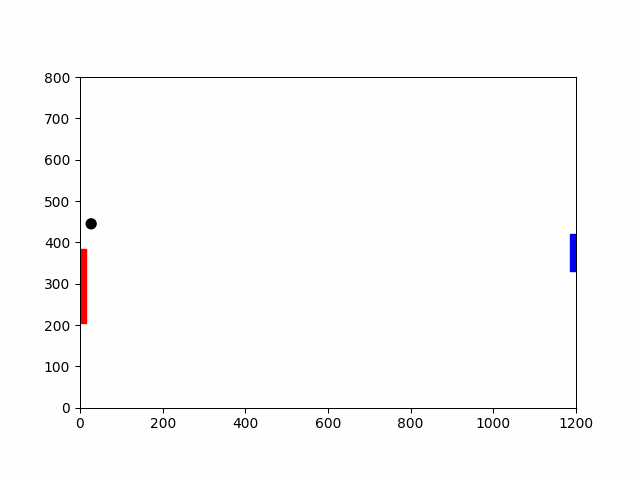

In [ ]:
env = CustomPongEnv()
# model = PPO.load(f"{path}/ppo_custom_pong_{name}.{iteration+1}")
model = PPO.load(f"./logs/best_model")

count = 0
obs, _ = env.reset()
for _ in range(1000000):
    action, _states = model.predict(obs)
    obs, rewards, done, info, _ = env.step(action)
    # print(rewards)
    env.render()
    if done:
        print("resetting due to done")
        print(env.state)
        if count == 3:
          break
        obs, _ = env.reset()
        count+=1

env.close()


In [ ]:
# Load the trained PPO model
model = PPO.load(f"{path}/ppo_custom_pong_{name}.{iteration+1}")

# Extract the PyTorch model's weights
policy_weights = model.policy.state_dict()

# Define the TensorFlow model
class TfPPOPolicy(tf.Module):
    def __init__(self, input_dim, output_dim):
        super(TfPPOPolicy, self).__init__()
        self.fc1 = layers.Dense(64, activation='relu', input_shape=(input_dim,))
        self.fc2 = layers.Dense(64, activation='relu')
        self.action_head = layers.Dense(output_dim)
        self.value_head = layers.Dense(1)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 8], dtype=tf.float32)])
    def __call__(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        action_logits = self.action_head(x)
        value = self.value_head(x)
        return action_logits, value

    def predict(self, x):
        action_logits, value = self.__call__(x)
        # Apply sigmoid to the buttonPressed logits to constrain between 0 and 1
        buttonPressed = tf.sigmoid(action_logits[:, 0])
        paddleDirection = action_logits[:, 1]
        return buttonPressed, paddleDirection


# Create the TensorFlow model
input_dim = 8  # Your observation space dimension
output_dim = 2  # Number of actions
tf_policy = TfPPOPolicy(input_dim, output_dim)

# Load weights into the TensorFlow model
tf_policy.fc1.build((None, input_dim))
tf_policy.fc1.set_weights([
    policy_weights['mlp_extractor.policy_net.0.weight'].cpu().numpy().T,
    policy_weights['mlp_extractor.policy_net.0.bias'].cpu().numpy()
])

tf_policy.fc2.build((None, 64))
tf_policy.fc2.set_weights([
    policy_weights['mlp_extractor.policy_net.2.weight'].cpu().numpy().T,
    policy_weights['mlp_extractor.policy_net.2.bias'].cpu().numpy()
])

tf_policy.action_head.build((None, 64))
tf_policy.action_head.set_weights([
    policy_weights['action_net.weight'].cpu().numpy().T,
    policy_weights['action_net.bias'].cpu().numpy()
])

tf_policy.value_head.build((None, 64))
tf_policy.value_head.set_weights([
    policy_weights['value_net.weight'].cpu().numpy().T,
    policy_weights['value_net.bias'].cpu().numpy()
])

# Save the wrapped policy as a TensorFlow SavedModel
saved_model_path = "./saved_model"
tf.saved_model.save(tf_policy, saved_model_path)

# Convert the SavedModel to TensorFlow.js format using the command line
# !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./saved_model ./tfjs_model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
iteration = 4
model = PPO.load(f"{path}/ppo_custom_pong_{name}.{iteration+1}")

# Extract PyTorch model's weights
policy_weights = model.policy.state_dict()

# Define the TensorFlow model
class TfPPOPolicy(tf.Module):
    def __init__(self, input_dim, output_dim):
        super(TfPPOPolicy, self).__init__()
        self.fc1_policy = layers.Dense(64, activation='tanh', name='fc1_policy')
        self.fc2_policy = layers.Dense(64, activation='tanh', name='fc2_policy')
        self.fc1_value = layers.Dense(64, activation='tanh', name='fc1_value')
        self.fc2_value = layers.Dense(64, activation='tanh', name='fc2_value')
        self.action_head = layers.Dense(output_dim, name='action_head')
        self.value_head = layers.Dense(1, name='value_head')

        # Build the layers by running a dummy input through the network
        dummy_input = tf.random.uniform((1, input_dim))
        self.__call__(dummy_input)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 8], dtype=tf.float32)])
    def __call__(self, x):
        policy_x = self.fc1_policy(x)
        policy_x = self.fc2_policy(policy_x)
        action_logits = self.action_head(policy_x)

        value_x = self.fc1_value(x)
        value_x = self.fc2_value(value_x)
        value = self.value_head(value_x)

        return action_logits, value

    def predict(self, x):
        action_logits, value = self.__call__(x)
        buttonPressed = tf.sigmoid(action_logits[:, 0])
        paddleDirection = action_logits[:, 1]
        return buttonPressed, paddleDirection

# Instantiate the TensorFlow model
input_dim = 8  # Adjust based on your actual input dimension
output_dim = 2  # Adjust based on your actual output dimension
tf_policy = TfPPOPolicy(input_dim, output_dim)

# Helper function to assign weights
def assign_weights(tf_model, torch_weights):
    # Assign policy network weights
    tf_model.fc1_policy.kernel.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.policy_net.0.weight'].t().numpy(), dtype=tf.float32))
    tf_model.fc1_policy.bias.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.policy_net.0.bias'].numpy(), dtype=tf.float32))
    tf_model.fc2_policy.kernel.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.policy_net.2.weight'].t().numpy(), dtype=tf.float32))
    tf_model.fc2_policy.bias.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.policy_net.2.bias'].numpy(), dtype=tf.float32))

    # Assign value network weights
    tf_model.fc1_value.kernel.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.value_net.0.weight'].t().numpy(), dtype=tf.float32))
    tf_model.fc1_value.bias.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.value_net.0.bias'].numpy(), dtype=tf.float32))
    tf_model.fc2_value.kernel.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.value_net.2.weight'].t().numpy(), dtype=tf.float32))
    tf_model.fc2_value.bias.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.value_net.2.bias'].numpy(), dtype=tf.float32))

    # Assign action and value head weights
    tf_model.action_head.kernel.assign(tf.convert_to_tensor(torch_weights['action_net.weight'].t().numpy(), dtype=tf.float32))
    tf_model.action_head.bias.assign(tf.convert_to_tensor(torch_weights['action_net.bias'].numpy(), dtype=tf.float32))
    tf_model.value_head.kernel.assign(tf.convert_to_tensor(torch_weights['value_net.weight'].t().numpy(), dtype=tf.float32))
    tf_model.value_head.bias.assign(tf.convert_to_tensor(torch_weights['value_net.bias'].numpy(), dtype=tf.float32))

# Assign the weights
assign_weights(tf_policy, model.policy.state_dict())

# Get intermediate outputs from the PyTorch model
def get_pytorch_intermediate_outputs(model, input_data):
    with th.no_grad():
        x = input_data
        x1 = model.policy.mlp_extractor.policy_net[0](x)
        x2 = model.policy.mlp_extractor.policy_net[2](x1)
        action_logits = model.policy.action_net(x2)
        value_x1 = model.policy.mlp_extractor.value_net[0](x)
        value_x2 = model.policy.mlp_extractor.value_net[2](value_x1)
        value = model.policy.value_net(value_x2)
    return x1, x2, action_logits, value_x1, value_x2, value

# Get intermediate outputs from the TensorFlow model
def get_tf_intermediate_outputs(model, input_data):
    policy_x1 = model.fc1_policy(input_data)
    policy_x2 = model.fc2_policy(policy_x1)
    action_logits = model.action_head(policy_x2)
    value_x1 = model.fc1_value(input_data)
    value_x2 = model.fc2_value(value_x1)
    value = model.value_head(value_x2)
    return policy_x1, policy_x2, action_logits, value_x1, value_x2, value

# Test the conversion with a small input
test_input = th.rand(1, input_dim)  # Use a fixed test input
torch_policy_x1, torch_policy_x2, torch_action_logits, torch_value_x1, torch_value_x2, torch_value = get_pytorch_intermediate_outputs(model, test_input)

# Ensure the input to TensorFlow is identical
tf_input = tf.convert_to_tensor(test_input.numpy(), dtype=tf.float32)
tf_policy_x1, tf_policy_x2, tf_action_logits, tf_value_x1, tf_value_x2, tf_value = get_tf_intermediate_outputs(tf_policy, tf_input)

# Print intermediate outputs
print("PyTorch policy fc1 output:", torch_policy_x1.detach().numpy())
print("TensorFlow policy fc1 output:", tf_policy_x1.numpy())

print("PyTorch policy fc2 output:", torch_policy_x2.detach().numpy())
print("TensorFlow policy fc2 output:", tf_policy_x2.numpy())

print("PyTorch action logits:", torch_action_logits.detach().numpy())
print("TensorFlow action logits:", tf_action_logits.numpy())

print("PyTorch value fc1 output:", torch_value_x1.detach().numpy())
print("TensorFlow value fc1 output:", tf_value_x1.numpy())

print("PyTorch value fc2 output:", torch_value_x2.detach().numpy())
print("TensorFlow value fc2 output:", tf_value_x2.numpy())

print("PyTorch value:", torch_value.detach().numpy())
print("TensorFlow value:", tf_value.numpy())

saved_model_path = "./saved_model_new"
tf.saved_model.save(tf_policy, saved_model_path)


PyTorch policy fc1 output: [[-0.15904823 -0.0670957   0.10368206  0.30483988  0.01337119 -0.24508096
  -0.3546461  -0.48025256  0.03984199  0.63393235 -0.09844951  0.41337955
  -0.11019313  0.45303807  0.11283946  0.28443953 -0.56069803  0.34210873
   0.23990984  0.22165376  0.20915824 -0.1377928  -0.06990146  0.16214462
  -0.00795686 -0.3767324   0.02442205  0.01465188  0.05508695  0.1515808
   0.09872608  0.12319711 -0.11831853 -0.47226366 -0.24919662  0.0546505
  -0.16687143  0.12732671 -0.2569833  -0.1844132   0.19296348 -0.44674465
   0.30742025  0.02844924  0.28813526 -0.13057217 -0.12696053 -0.05529656
  -0.624382   -0.11825649  0.5915864  -0.21161465  0.24253242  0.25089306
   0.26347867  0.00536796  0.13035037  0.09258169  0.02575868  0.28844428
  -0.4807719   0.38800618 -0.3156076   0.21997526]]
TensorFlow policy fc1 output: [[-0.15772057 -0.06699519  0.10331212  0.29573548  0.0133704  -0.24028914
  -0.34048945 -0.44644582  0.03982091  0.560754   -0.09813269  0.39133838
  -0.

In [ ]:
# Convert the SavedModel to TensorFlow.js format using the command line
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./saved_model_new ./tfjs_model

2024-06-04 15:18:50.093334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
%pip install pygame